In [1]:
import numpy as np
import pandas as pd
import datatable as dt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm, skew 
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns 
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



/kaggle/input/playground-series-s3e1/sample_submission.csv
/kaggle/input/playground-series-s3e1/train.csv
/kaggle/input/playground-series-s3e1/test.csv


<font size=5>**Download the data and check the data shape**</font>

In [2]:
train = dt.fread('../input/playground-series-s3e1/train.csv').to_pandas().drop('id', axis=1)
train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [3]:
test = dt.fread('../input/playground-series-s3e1/test.csv').to_pandas().drop('id', axis=1)
test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


In [4]:
r1,c1 = train.shape
print('The training data has {} rows and {} columns'.format(r1,c1))
r2,c2 = test.shape
print('The test data has {} rows and {} columns'.format(r2,c2))

The training data has 37137 rows and 9 columns
The test data has 24759 rows and 8 columns


Note: This dataset is generated by deep learning model and in most other notebooks it is suggested to use the original dataset along with this data.

Downloading the original data

In [5]:
from sklearn.datasets import fetch_california_housing

original_data = fetch_california_housing()
original_data = pd.DataFrame(data=np.hstack([original_data['data'], original_data['target'].reshape(-1, 1)]), columns=train.columns)
train = pd.concat([train, original_data]).reset_index(drop=True)

In [6]:
# To see the quantity of null vaues in all the columns.
# c1 stands for the number of columns in the training data.

print('MISSING VALUES IN TRAINING DATASET:')
print(train.isna().sum().nlargest(c1))
print('')
print('MISSING VALUES IN TEST DATASET:')
print(test.isna().sum().nlargest(c2))

MISSING VALUES IN TRAINING DATASET:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

MISSING VALUES IN TEST DATASET:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


<font size=5>**Graph**</font>

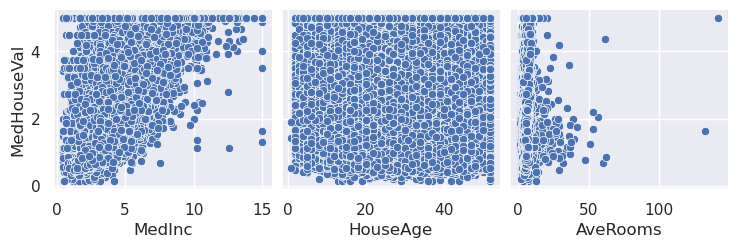

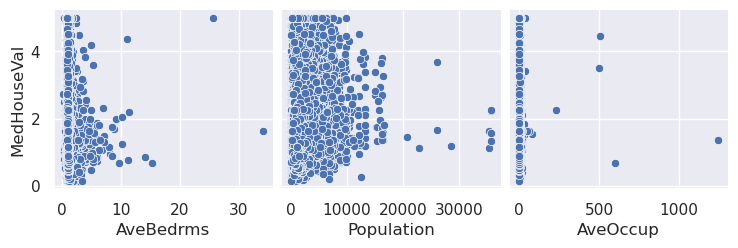

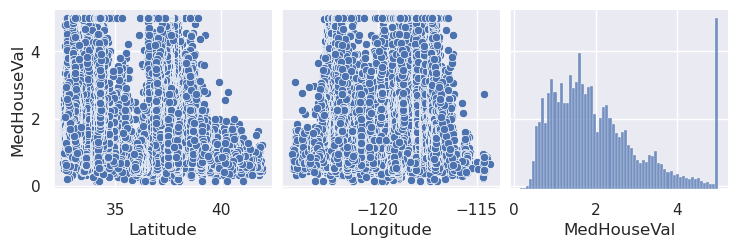

In [7]:
sns.set()

for i in range(3):
    sns.pairplot(train, x_vars=train.columns.values[3*i:3*(i+1)], y_vars="MedHouseVal")
plt.show()

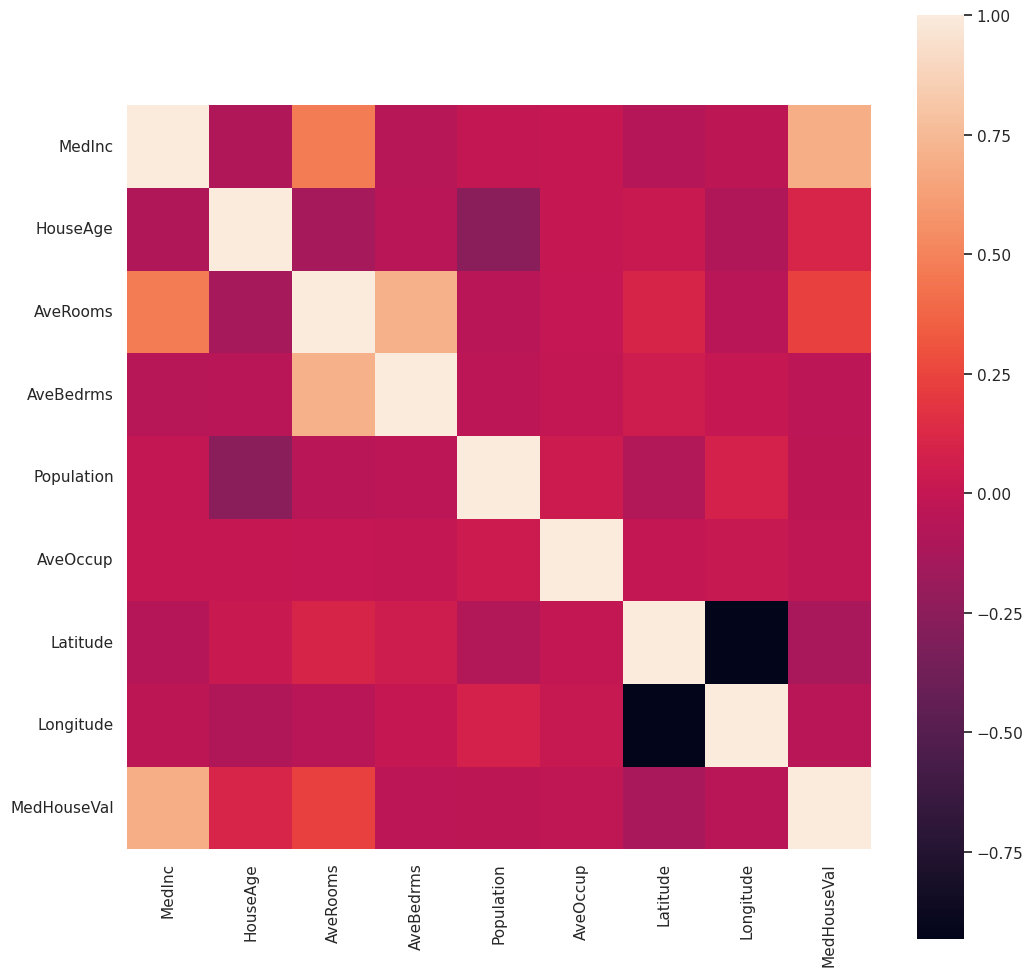

In [8]:
#correlation matrix
corrmat = train.corr()
corrmat.sort_values('MedHouseVal',ascending=False).index
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=1, square=True);

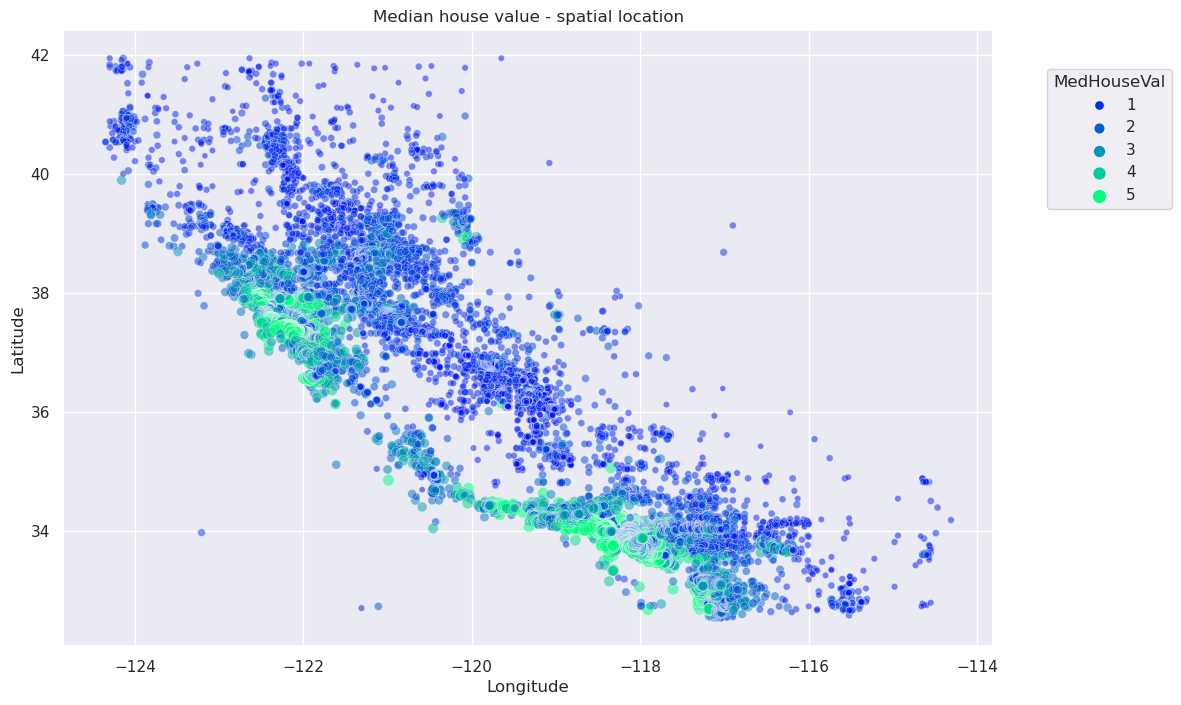

In [9]:
plt.figure(figsize = (12, 8))

sns.scatterplot(data = train, x = "Longitude", y = "Latitude",
                size = "MedHouseVal", hue = "MedHouseVal",
                palette = "winter", alpha = 0.5)

plt.legend(title = "MedHouseVal", bbox_to_anchor = (1.05, 0.95), loc = 2)
plt.title("Median house value - spatial location")
plt.show()

<font size=5>**To segment X_train,X_test, y_train,y_test**</font>

In [10]:
def rt_crds(df): 
    
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                      (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) - \
                      (np.sin(np.radians(15)) * df['Longitude'])
    
    df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                      (np.sin(np.radians(30)) * df['Latitude'])
    
    df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) - \
                      (np.sin(np.radians(30)) * df['Longitude'])
    
    df['rot_45_x'] = (np.cos(np.radians(45)) * df['Longitude']) + \
                      (np.sin(np.radians(45)) * df['Latitude'])
    
    df['rot_45_y'] = (np.cos(np.radians(45)) * df['Latitude']) - \
                      (np.sin(np.radians(45)) * df['Longitude'])

    return df

train = rt_crds(train)
test = rt_crds(test)

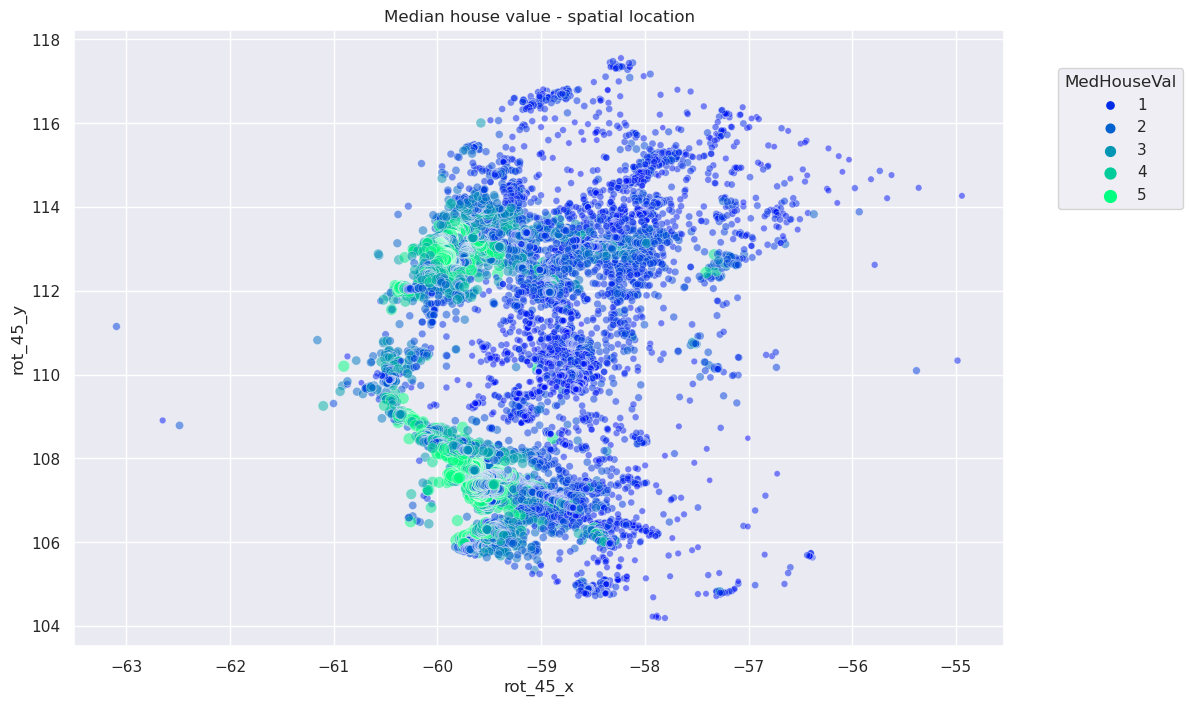

In [11]:
plt.figure(figsize = (12, 8))

sns.set_theme(style='darkgrid')
sns.scatterplot(data = train, x = "rot_45_x", y = "rot_45_y",
                size = "MedHouseVal", hue = "MedHouseVal",
                palette = "winter", alpha = 0.5)

plt.legend(title = "MedHouseVal", bbox_to_anchor = (1.05, 0.95), loc = 2)
plt.title("Median house value - spatial location")
plt.show()

In [12]:
train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,-107.071871,64.510377,-86.726972,90.024479,-60.471772,109.403561
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,-107.075820,68.745715,-85.634599,94.116523,-58.357523,113.073445
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,-107.362157,64.702039,-86.957760,90.284742,-60.627335,109.714688
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,-104.647225,61.852259,-85.072915,86.829390,-59.701026,105.889240
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,-108.455620,68.194036,-87.110170,93.940760,-59.828305,113.285577


In [13]:
train.shape

(57777, 15)

In [14]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 
            'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']
y = train['MedHouseVal']
X_train,X_test, y_train,y_test = train_test_split(train[features],train['MedHouseVal'],test_size=0.25)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43332, 14), (14445, 14), (43332,), (14445,))

In [15]:
test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85,-107.410005,69.932652,-85.650195,95.349510,-58.053467,114.268456
1,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29,-105.472459,63.408887,-85.467145,88.546562,-59.637386,107.649936
2,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81,-105.096813,62.956239,-85.221453,88.012114,-59.538391,107.070109
3,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34,-105.463816,63.634331,-85.400446,88.762088,-59.517178,107.840855
4,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29,-105.415519,63.621390,-85.357145,88.737088,-59.481822,107.805500


<font size=5>**Training model setting**</font>

In [16]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
import math

MODEL_PARAMS = {       'n_estimators': 1200, 
                       'learning_rate': 0.04,
                       'max_depth': 6,
                       'colsample_bytree': 0.87,
                       'subsample': 0.85,
                       'reg_lambda': 20,
                       'tree_method': 'gpu_hist',
                       'seed': 42                   
}

xgbr = xgb.XGBRegressor(**MODEL_PARAMS)
xgbr.fit(X_train, y_train)
 
score = xgbr.score(X_train, y_train)   
print("Training score: ", score) 
 
#cross validataion 
scores = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


ypred2 = xgbr.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, ypred2))
print("RMSE: %.5f" % rmse)

Training score:  0.880650192942272
Mean cross-validation score: 0.79
K-fold CV average score: 0.80
RMSE: 0.51769


<font size=5>**Testing**</font>

In [17]:
test_preds = xgbr.predict(test)

#Check the form of submission 
submission_df = pd.read_csv('../input/playground-series-s3e1/sample_submission.csv')
submission_df

,id,MedHouseVal
0,37137,2.079751
1,37138,2.079751
2,37139,2.079751
3,37140,2.079751
4,37141,2.079751
...,...,...
24754,61891,2.079751
24755,61892,2.079751
24756,61893,2.079751
24757,61894,2.079751


<font size=5>**Submission**</font>

In [18]:
test_preds #one array
submission_df['MedHouseVal'] = test_preds
submission_df.to_csv('submission.csv', index=False)

In [19]:
test_preds 

array([0.65029305, 1.0298476 , 3.837978  , ..., 1.2068783 , 3.6762118 ,
       3.7117383 ], dtype=float32)

In [20]:
# Solution table in the dataset
solution = pd.read_csv('submission.csv')
solution

,id,MedHouseVal
0,37137,0.650293
1,37138,1.029848
2,37139,3.837978
3,37140,3.418795
4,37141,2.270022
...,...,...
24754,61891,2.509421
24755,61892,1.840007
24756,61893,1.206878
24757,61894,3.676212
